# Get data

In [8]:
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, zscore

from tensorflow import keras
from gan import GAN

In [9]:
raw_data = yf.download('^GSPC','2009-05-01','2018-12-31')

[*********************100%***********************]  1 of 1 completed


In [10]:
def delta_GMM(x, gamma_0=3):
  delta_0 = 1 / 66 * (np.sqrt(66 * gamma_0 - 162) - 6)

  def f(delta):
    u_delta = W_delta(x, delta)
    gamma = kurtosis(u_delta, fisher=False)
    return np.abs(gamma - gamma_0)

  res = fmin(f, delta_0, disp=False)

  return res[0]


def W_delta(z, delta):
  return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)


def IGMM(y, tol=1e-6, n_max=1000):
  tau_prev = np.array([0, 0, 0])
  gamma = kurtosis(y, fisher=False)
  delta = 1 / 66 * (np.sqrt(66 * gamma - 162) - 6)
  tau = np.array([np.median(y), np.std(y) * np.power(1 - 2 * delta, 0.75), delta])
  k = 0
  
  while np.linalg.norm(tau - tau_prev) > tol and k < n_max:

    tau_prev = tau.copy()
    z = (y - tau[0]) / tau[1]
    tau[2] = delta_GMM(z) #at k+1
    x = W_delta((z - tau[0]) / tau[1], tau[2]) * tau[1] + tau[0] 
    tau[0], tau[1] = np.mean(x), np.std(x)
    k = k + 1
    
  if k > n_max:
    raise RuntimeError(f"IGMM did not converge after {n_max} iterations")
  return tau

def rolling_window(array, window_size,freq):
  shape = (array.shape[0] - window_size + 1, window_size)
  strides = (array.strides[0],) + array.strides
  rolled = np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)
  return rolled[np.arange(0,shape[0],freq)]
    

In [11]:
# 1) Log returns
logret = np.diff(np.log(raw_data['Close']))
# 2) Standardize
logret_norm = zscore(logret)
# 3) Inverse Lambert W transform
#gamma_0 = kurtosis(logret_norm)
tau = IGMM(logret_norm)
processed = W_delta((logret_norm - tau[0]) / tau[1], tau[2])
# 4) Normalize
processed_norm = zscore(processed)
# 5) Rolling window
data = rolling_window(processed_norm, 127, 5)


<ipython-input-10-4bdfcaa40c41>:15: RuntimeWarning: invalid value encountered in true_divide
  return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)


<AxesSubplot:xlabel='Log Returns', ylabel='Density'>

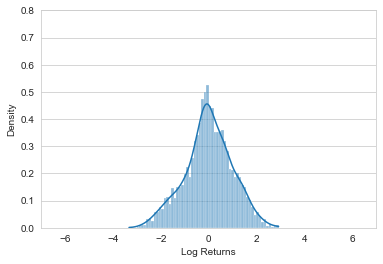

In [34]:
fig, ax = plt.subplots()
ax.set_xlim(-7, 7)
ax.set_ylim(0, .8)
ax.set_xlabel('Log Returns')
ax.grid(axis='x')
sns.histplot(processed_norm, bins=60, stat='density', kde=True, ax=ax)

In [33]:
print(f"custom Lambert W x Log returns mean={processed.mean():.3f}, std={processed.std():.3f}")
print(f"from the paper mean=0.055, std=0.705")

custom Lambert W x Log returns mean=0.006, std=0.870
from the paper mean=0.055, std=0.705


# Train model

In [ ]:
data = np.expand_dims(data, 2)
data.shape

In [ ]:
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

In [ ]:
latent_size = 3
hidden_size = 80
output_size = 1
d_train_steps = 5

gan = GAN(latent_size, hidden_size, output_size, d_train_steps)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy()
)

gan.fit(dataset, epochs=10)

In [ ]:
latent_noise = tf.random.normal(shape=(1, 2433, 3))
fake = gan.generator(latent_noise).numpy().reshape(2433)

In [ ]:
plt.hist(fake, bins=50)
plt.show()

In [ ]:
fake.mean()

In [ ]:
data.mean()